# #The Impact of Clinical Trial Results on Pharmaceutical Stock Performance

Step 1) Collect Data

1.1 Set up Google Alerts by going to: https://www.google.com/alerts
        Set alerts to capture news or other articles pertaining to the subject matter
        Collected up to date information on clinical trials using key words: 
            "Phase III trail"
            "Phase 3 trial"
            "Meets Primary End Point"

1.2 Access Google Alert Snippits with Gmail API:
    1.2.1 Go to: https://developers.google.com/gmail/api/quickstart/python to configure Authentication
    1.2.2 Make sure the client_secret.json is in the same directory
    1.2.3 Run Google API parsing script



In [ ]:
'''
Tiffany Fabianac Modified code from:
Reading GMAIL using Python
    - https://github.com/abhishekchhibber/Gmail-Api-through-Python
	- Abhishek Chhibber
'''

'''
This script does the following:
- Go to Gmal inbox
- Find and read all the Google Alert messages
- Extract details (Date, Snippet) and export them to a .csv file / DB
'''

'''
Before running this script, the user should get the authentication by following 
the link: https://developers.google.com/gmail/api/quickstart/python
Also, client_secret.json should be saved in the same directory as this file
'''

# Importing required libraries
from apiclient import discovery
from apiclient import errors
from httplib2 import Http
from oauth2client import file, client, tools
import base64
from bs4 import BeautifulSoup
import re
import time
import dateutil.parser as parser
from datetime import datetime
import datetime
import csv
import json
import io

# Creating a storage.JSON file with authentication details
SCOPES = 'https://www.googleapis.com/auth/gmail.modify'  # we are using modify and not readonly, as we will be marking the messages Read
store = file.Storage('storage.json')
creds = store.get()
if not creds or creds.invalid:
    flow = client.flow_from_clientsecrets('client_secret.json', SCOPES)
    creds = tools.run_flow(flow, store)
GMAIL = discovery.build('gmail', 'v1', http=creds.authorize(Http()))

user_id = 'me'
label_id_one = 'INBOX'

# Getting all the unread messages from Inbox
# labelIds can be changed accordingly
alert_msgs = GMAIL.users().messages().list(userId='me', labelIds=[label_id_one], q='from:googlealerts-noreply@google.com').execute()

# We get a dictonary. Now reading values for the key 'messages'
mssg_list = alert_msgs['messages']

final_list = []

for mssg in mssg_list:
    temp_dict = {}
    m_id = mssg['id']  # get id of individual message
    message = GMAIL.users().messages().get(userId=user_id, id=m_id).execute()  # fetch the message using API
    payld = message['payload']  # get payload of the message
    headr = payld['headers']  # get header of the payload

    for two in headr:  # getting the date
        if two['name'] == 'Date':
            msg_date = two['value']
            date_parse = (parser.parse(msg_date))
            m_date = (date_parse.date())
            temp_dict['Date'] = str(m_date)
        else:
            pass

    temp_dict['Snippet'] = message['snippet']



    final_list=json.dumps(temp_dict)  # This will create a dictonary item in the final list
    re.sub(r'\u22c5', '', final_list)
    print final_list

# exporting the values as .csv
#final_list = json.loads(final_list)
with open("API_out.csv", "a") as f:
    header=["Date", "Snippet"]
    writer = csv.DictWriter(f, fieldnames=header, delimiter=',')
    for x in final_list:
        writer.writerow(x)


Date	Ticker	Snippit	W/L?	%Change
2017-08-22	ABEO	 Abeona Therapeutics - String Of Pearls Strategy With Numerous Catalysts And A Lot Of Upside		
2017-08-22	ALKS	FDA Approves IRWD's Gout Drug, It's A Thumbs Up For ALXN In EU, CRME Crushed		
2017-08-22	ALPMY	FDA Approves IRWD's Gout Drug, It's A Thumbs Up For ALXN In EU, CRME Crushed		
2017-08-22	ALXN	FDA Approves IRWD's Gout Drug, It's A Thumbs Up For ALXN In EU, CRME Crushed		
2017-08-22	ARRY	 Array Biopharma (ARRY) Reaches $8.58 After 7.00% Down Move; Per Se Technologies (PSTI		
2017-08-22	AXON	FDA Approves IRWD's Gout Drug, It's A Thumbs Up For ALXN In EU, CRME Crushed		
2017-08-22	BLRX	BioLineRx Moves a Regulatory Submission for BL-8040 Trial		
2017-08-22	BLRX	BioLineRx Moves a Regulatory Submission for BL-8040 Trial		
2017-11-19	BLRX	 BioLineRx Ltd. (BLRX) Receives Average Recommendation of “Buy” from Analysts The Lincolnian Online Its clinical therapeutic		
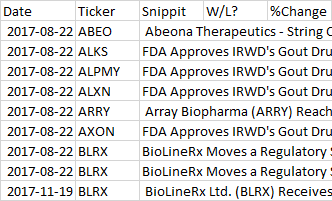

1.3 The stock symbols had to be manually extracted from the Snippets (Sad day) 

1.4 Find out if the stocks associate with these Google Alerts had an signigifant (10%) price increase within 5 days (including weekends) from the alert:

In [ ]:
from pandas_datareader import data
import pandas as pd
import csv
import string
import datetime
from collections import defaultdict
from pandas.tseries.offsets import BDay


def stockData(startDate, endDate, ticker):
    # Define which online source one should use
    data_source = 'google'

    # User pandas_reader.data.DataReader to load the desired data.
    panel_data = data.DataReader(ticker, data_source, startDate, endDate)

    close = panel_data.ix['Close']
    volume = panel_data.ix['Volume']
    op = panel_data.ix['Open']
    high = panel_data.ix['High']
    low = panel_data.ix['Low']

    # Getting all weekdays between 01/01/2017 and 12/31/2017
    all_weekdays = pd.date_range(start=startDate, end=endDate, freq='B')

    # Align new set of dates
    close = close.reindex(all_weekdays)
    volume = volume.reindex(all_weekdays)
    op = op.reindex(all_weekdays)
    high = high.reindex(all_weekdays)
    low = low.reindex(all_weekdays)

    result = pd.concat([close, volume, op, high, low], axis=1, join='inner')
    result.columns = ['close', 'volume', 'open', 'high', 'low']
    return result


def findHigh(startDate, ticker):
    # Get date and five days after
    temp_date = datetime.datetime.strptime(startDate, "%Y-%m-%d")
    endDate = temp_date + BDay(5)

    result = stockData(startDate, endDate, ticker)
    tempHigh = result.nlargest(1, 'high')
    high = tempHigh.iloc[0]['high']
    return high


def openPrice(startDate, ticker):
    temp_date = datetime.datetime.strptime(startDate, "%Y-%m-%d")
    endDate = temp_date + BDay(1)

    result = stockData(startDate, endDate, ticker)
    open = result.iloc[0]['open']
    return open


with open('google_alert_data.csv', 'rb') as csvfile:
    with open('labeledTrainData.csv', 'wb') as f:
        datareader = csv.DictReader(csvfile)
        writer = csv.DictWriter(f, fieldnames=datareader.fieldnames, extrasaction='ignore', delimiter=',',
                                skipinitialspace=True)
        writer.writeheader()
        for line in datareader:
            if (line['Ticker'] == ''):
                pass
            elif (line['Snippit'] == ''):
                pass
            else:
                ticker = [line['Ticker']]
                date = line['Date']
                high = findHigh(date, ticker)
                startPrice = openPrice(date, ticker)
                prctIncrease = round(((high - startPrice) / startPrice) * 100, 2)
                if (high > startPrice * 1.1):
                    line['W/L?'] = 'W'
                    line['%Change'] = prctIncrease
                    print ticker, prctIncrease, high, startPrice, date
                else:
                    line['W/L?'] = 'L'
                    line['%Change'] = prctIncrease
                line['Snippit'] = line['Snippit'].replace(',', '')
                writer.writerow(line)

Date	Ticker	Snippit	W/L?	%Change
2017-08-22	ABEO	 Abeona Therapeutics - String Of Pearls Strategy With Numerous Catalysts And A Lot Of Upside	W	46.1
2017-08-22	ALKS	FDA Approves IRWD's Gout Drug It's A Thumbs Up For ALXN In EU CRME Crushed	L	0.39
2017-08-22	ALPMY	FDA Approves IRWD's Gout Drug It's A Thumbs Up For ALXN In EU CRME Crushed	L	1.6
2017-08-22	ALXN	FDA Approves IRWD's Gout Drug It's A Thumbs Up For ALXN In EU CRME Crushed	L	5.28
2017-08-22	ARRY	 Array Biopharma (ARRY) Reaches $8.58 After 7.00% Down Move; Per Se Technologies (PSTI	W	16.34
2017-08-22	AXON	FDA Approves IRWD's Gout Drug It's A Thumbs Up For ALXN In EU CRME Crushed	L	1.24
2017-08-22	BLRX	BioLineRx Moves a Regulatory Submission for BL-8040 Trial	L	6.42
2017-08-22	BLRX	BioLineRx Moves a Regulatory Submission for BL-8040 Trial	L	6.42
2017-11-19	BLRX	 BioLineRx Ltd. (BLRX) Receives Average Recommendation of “Buy” from Analysts The Lincolnian Online Its clinical therapeutic	L	6.48
2017-08-22	BPMC	FDA Approves IRWD's Gout Drug It's A Thumbs Up For ALXN In EU CRME Crushed	W	24.42


Step 2) Analyze Data using random tree analysis

In [ ]:
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from KaggleWord2VecUtility import KaggleWord2VecUtility
import pandas as pd
import nltk

if __name__ == '__main__':
    train = pd.read_csv(os.path.join(os.path.dirname(__file__), 'labeledTrainData.csv'), header=0, delimiter=",", quoting=3)
    test = pd.read_csv(os.path.join(os.path.dirname(__file__), 'testData.csv'), header=0, delimiter=",", quoting=3)

    print 'The first review is:'
    print train['Snippit'][0]
    raw_input("Press Enter to continue...")

    print 'Download text data sets'
    nltk.download()
    clean_train_reviews = []
    print "Cleaning and parsing the training set...\n"
    for i in xrange(0, len(train['Snippit'])):
        clean_train_reviews.append(" ".join(KaggleWord2VecUtility.review_to_wordlist(train['Snippit'][i], True)))

    print "Creating the bag of words...\n"
    vectorizer = CountVectorizer(analyzer="word", tokenizer=None, preprocessor=None, stop_words=None, max_features=5000)
    train_data_features = vectorizer.fit_transform(clean_train_reviews)
    train_data_features = train_data_features.toarray()

    print "Training Random forest..."
    forest = RandomForestClassifier(n_estimators=100)
    forest = forest.fit(train_data_features, train['W/L?'])
    clean_test_reviews=[]

    print "Cleaning and parsing \n"
    for i in xrange(0,len(test['Snippit'])):
        clean_test_reviews.append(" ".join(KaggleWord2VecUtility.review_to_wordlist(test['Snippit'][i], True)))
    test_data_features = vectorizer.transform(clean_test_reviews)
    test_data_features = test_data_features.toarray()

    print "Predicting test labels...\n"
    result = forest.predict(test_data_features)
    output = pd.DataFrame(data={"Accuracy":"", "Sentiment":result, "Ticker":test["Ticker"], "Date":test["Date"]})
    output.to_csv(os.path.join(os.path.dirname(__file__), 'randomForestResults.csv'), index=False, quoting=3)
    print "Wrote results to randomForestResults.csv"

Accuracy	Date	Sentiment	Ticker
           2017-12-03	L	ABBV
           2017-12-01	L	ABBV
           2017-11-30	L	ACAD
           2017-12-02	L	ALNY
           2017-12-03	L	ARGX
           2017-12-02	L	BABA
           2017-12-01	L	BAYN
           2017-12-03	L	BPMX
           2017-12-02	L	CISN
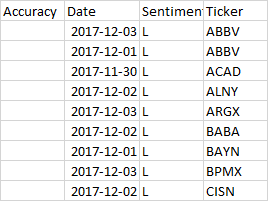

Step 3) Determine Accuracy:

In [ ]:
from pandas_datareader import data
import pandas as pd
import csv
import string
import datetime
from collections import defaultdict
from pandas.tseries.offsets import BDay


def stockData(startDate, endDate, ticker):
    # Define which online source one should use
    data_source = 'google'

    # User pandas_reader.data.DataReader to load the desired data.
    panel_data = data.DataReader(ticker, data_source, startDate, endDate)

    close = panel_data.ix['Close']
    volume = panel_data.ix['Volume']
    op = panel_data.ix['Open']
    high = panel_data.ix['High']
    low = panel_data.ix['Low']

    # Getting all weekdays between 01/01/2017 and 12/31/2017
    all_weekdays = pd.date_range(start=startDate, end=endDate, freq='B')

    # Align new set of dates
    close = close.reindex(all_weekdays)
    volume = volume.reindex(all_weekdays)
    op = op.reindex(all_weekdays)
    high = high.reindex(all_weekdays)
    low = low.reindex(all_weekdays)

    result = pd.concat([close, volume, op, high, low], axis=1, join='inner')
    result.columns = ['close', 'volume', 'open', 'high', 'low']
    return result


def findHigh(startDate, ticker):
    # Get date and five days after
    endDate = datetime.datetime.today().strftime('%Y-%m-%d')

    result = stockData(startDate, endDate, ticker)
    if (result.iloc[0]['high'] != result.iloc[0]['high']):
        return 0
    else:
        tempHigh = result.nlargest(1, 'high')
        high = tempHigh.iloc[0]['high']
        return high


def openPrice(endDate, ticker):
    temp_date = datetime.datetime.strptime(endDate, "%Y-%m-%d")
    startDate = temp_date - BDay(1)

    result = stockData(startDate, endDate, ticker)
    if (result.iloc[0]['high'] != result.iloc[0]['high']):
        return 1
    else:
        open = result.iloc[0]['open']
        return open


with open('randomForestResults.csv', 'rb') as csvfile:
    with open('resultsData.csv', 'wb') as f:
        datareader = csv.DictReader(csvfile)
        writer = csv.DictWriter(f, fieldnames=datareader.fieldnames, extrasaction='ignore', delimiter=',',
                                skipinitialspace=True)
        writer.writeheader()
        for line in datareader:
            if (line['Ticker'] == '' or line['Sentiment'] == ''):
                pass
            else:
                ticker = [line['Ticker']]
                date = line['Date']
                high = findHigh(date, ticker)
                startPrice = openPrice(date, ticker)
                prctIncrease = round(((high - startPrice) / startPrice) * 100, 2)
                if (high > startPrice * 1.1 and line['Sentiment'] == 'W'):
                    line['Accuracy'] = 'W'
                    print ticker, prctIncrease, high, startPrice, date
                else:
                    line['Accuracy'] = 'L'
                writer.writerow(line)

Accuracy,Date,Sentiment,Ticker
L,2017-12-03,L,ABBV
L,2017-12-01,L,ABBV
L,2017-11-30,L,ACAD
L,2017-12-02,L,ALNY
L,2017-12-03,L,ARGX
L,2017-12-02,L,BABA
L,2017-12-01,L,BAYN
L,2017-12-03,L,BPMX
L,2017-12-02,L,CISN